# Eye Diseases Classification

# 1. Data Loading
## 1.1. Import Libraries

In [3]:
!pip install --upgrade tensorflow
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import time
from tqdm.notebook import tqdm as tq

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
print(tf.__version__)

2.17.0


## 1.2. Load Dataset

In [3]:
# Download eye disease dataset from kaggle
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
100% 734M/736M [00:07<00:00, 129MB/s]
100% 736M/736M [00:07<00:00, 99.2MB/s]


In [4]:
zip_file = '/content/eye-diseases-classification.zip'
destination_folder = '/content/eye-disease'

if not os.path.exists(destination_folder):
  os.makedirs(destination_folder)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
  zip_ref.extractall(destination_folder)

print("Extraction complete")

Extraction complete


# 2. Exploratory Data Analysis

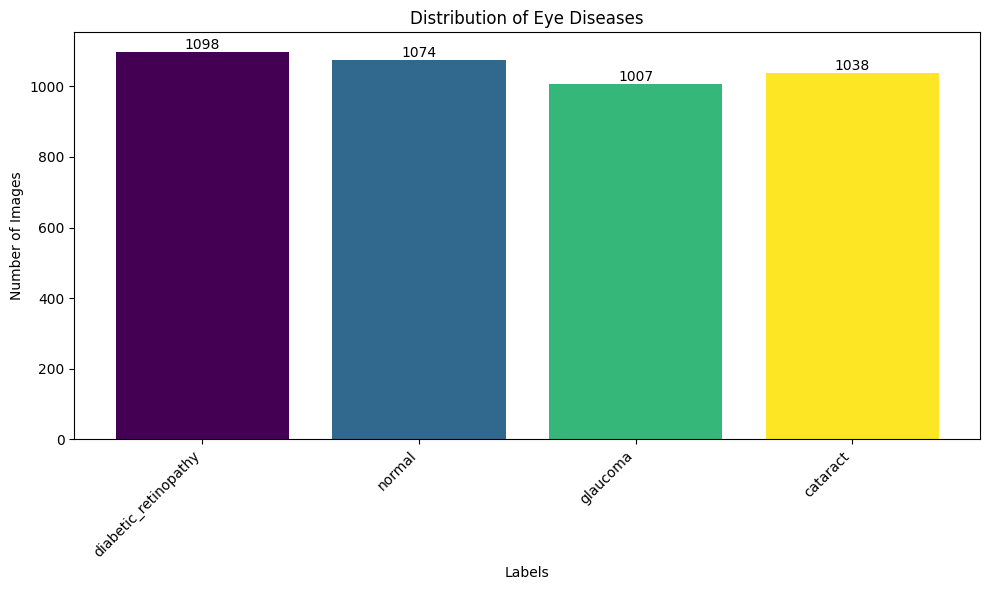

In [5]:
base_dir = '/content/eye-disease/dataset'

label_counts = {}

for label_name in os.listdir(base_dir):
    label_path = os.path.join(base_dir, label_name)

    if os.path.isdir(label_path):
        num_images = len([f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))])
        label_counts[label_name] = num_images

df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])

labels = df['Label'].tolist()
counts = df['Count'].tolist()

colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts, color=colors)

plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Distribution of Eye Diseases')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [39]:
def display_sample_img(data_dir, title):
  labels = [label for label in os.listdir(data_dir)
            if os.path.isdir(os.path.join(data_dir, label))
            and label not in ['train', 'test']]

  plt.figure(figsize=(12, 6))
  plt.suptitle(title, fontsize=16)

  for idx, label in enumerate(labels):
      label_path = os.path.join(data_dir, label)

      if len(os.listdir(label_path)) > 0:
          images = os.listdir(label_path)
          random_image = random.choice(images)

          img_path = os.path.join(label_path, random_image)
          img = mpimg.imread(img_path)

          plt.subplot(2, len(labels) // 2, idx + 1)
          plt.imshow(img)
          plt.axis('off')
          plt.title(f"{label}")

  plt.tight_layout()
  plt.show()

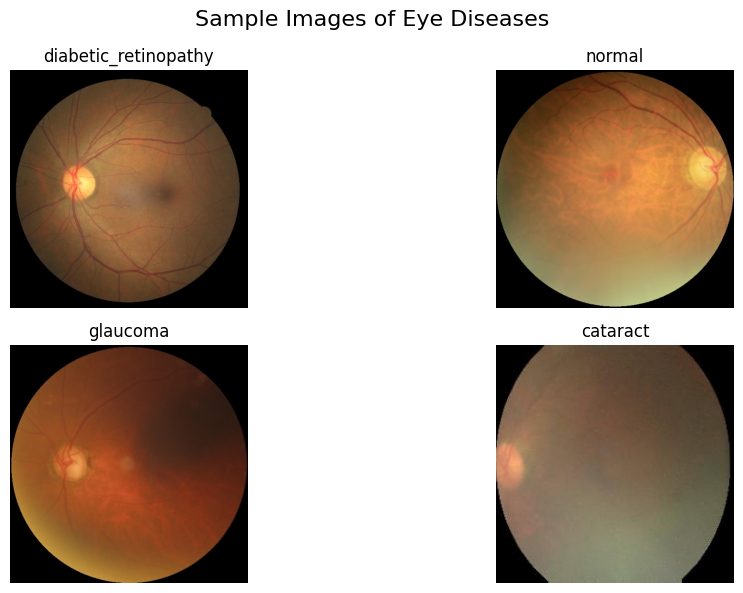

In [45]:
display_sample_img('/content/eye-disease/dataset', 'Sample Images of Eye Diseases')

# 3. Modeling

## 3.1. Data Splitting

In [8]:
dataset_dir = '/content/eye-disease/dataset'
desired_labels = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(dataset_dir):
  for name in files:
    label = os.path.basename(path)
    if label in desired_labels:
      full_path.append(os.path.join(path, name))
      labels.append(label)
      file_name.append(name)

df = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})
print(df.groupby(['labels']).size())

labels
cataract                1038
diabetic_retinopathy    1098
glaucoma                1007
normal                  1074
dtype: int64


In [9]:
X = df['path']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

df_train = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_test = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

In [10]:
print('train size', len(df_train))
print('test size', len(df_test))

train size 3373
test size 844


In [11]:
datasource_path = "/content/eye-disease/dataset"
dataset_path = "/content/eye-disease/dataset"

def move_files(df, source_path, target_path):
    for index, row in df.iterrows():
        file_path = row['path']
        label = row['labels']
        file_set = row['set']

        dest_dir = os.path.join(target_path, file_set, label)
        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir)

        destination_file_name = os.path.basename(file_path)
        file_dest = os.path.join(dest_dir, destination_file_name)

        if not os.path.exists(file_dest):
            shutil.copy2(file_path, file_dest)

move_files(df_train, datasource_path, dataset_path)
move_files(df_test, datasource_path, dataset_path)

print("The data has been moved and separated into train and test.")

The data has been moved and separated into train and test.


## 3.2. Data Augmentation

In [12]:
TRAIN_DIR = '/content/eye-disease/dataset/train'
TEST_DIR = '/content/eye-disease/dataset/test'

train_normal = os.path.join(TRAIN_DIR, 'normal')
train_diabetic_retinopathy = os.path.join(TRAIN_DIR, 'diabetic_retinopathy')
train_glaucoma = os.path.join(TRAIN_DIR, 'glaucoma')
train_cataract = os.path.join(TRAIN_DIR, 'cataract')

test_normal = os.path.join(TEST_DIR, 'normal')
test_diabetic_retinopathy = os.path.join(TEST_DIR, 'diabetic_retinopathy')
test_glaucoma = os.path.join(TEST_DIR, 'glaucoma')
test_cataract = os.path.join(TEST_DIR, 'cataract')

def count_images(directory):
    return len(os.listdir(directory))

train_counts = {
    'Normal': count_images(train_normal),
    'Diabetic Retinopathy': count_images(train_diabetic_retinopathy),
    'Glaucoma': count_images(train_glaucoma),
    'Cataract': count_images(train_cataract),
}

test_counts = {
    'Normal': count_images(test_normal),
    'Diabetic Retinopathy': count_images(test_diabetic_retinopathy),
    'Glaucoma': count_images(test_glaucoma),
    'Cataract': count_images(test_cataract),
}

print("Training Image Counts:", train_counts)
print("Testing Image Counts:", test_counts)

Training Image Counts: {'Normal': 859, 'Diabetic Retinopathy': 848, 'Glaucoma': 824, 'Cataract': 842}
Testing Image Counts: {'Normal': 215, 'Diabetic Retinopathy': 250, 'Glaucoma': 183, 'Cataract': 196}


In [13]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    class_mode='categorical',
    color_mode="rgb",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=False,
)

Found 3373 images belonging to 4 classes.
Found 844 images belonging to 4 classes.


In [14]:
print("classes: ", train_generator.class_indices)

classes:  {'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}


## 3.3. Model Architecture

In [4]:
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.keras import regularizers

In [17]:
input_shape = (224, 224, 3)
classes = 4

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = True

model = Sequential([
    base_model,
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 3.4. Model Training

In [18]:
def cyclic_lr(epoch, lr):
    base_lr = 1e-5
    max_lr = 1e-3
    step_size = 2000
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [19]:
class stopTraining(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    val_accuracy = logs.get('val_accuracy')
    val_loss = logs.get('val_loss')

    if val_accuracy is not None and val_loss is not None:
      if val_accuracy >= 0.93 and val_loss < 0.13:
        print('Akurasi di atas 93%, stop training')
        self.model.stop_training = True

stop_train = stopTraining()

In [20]:
callbacks = [
    stop_train,
    LearningRateScheduler(cyclic_lr),
    EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model_1.keras', monitor='val_loss', save_best_only=True, verbose=1, mode='min')
]

In [21]:
count_normal = len(os.listdir(train_normal))
count_diabetic_retinopathy = len(os.listdir(train_diabetic_retinopathy))
count_glaucoma = len(os.listdir(train_glaucoma))
count_cataract = len(os.listdir(train_cataract))

total_images = (count_normal + count_diabetic_retinopathy + count_glaucoma + count_cataract)

weight_normal = (1 / count_normal) * total_images / 4
weight_diabetic_retinopathy = (1 / count_diabetic_retinopathy) * total_images / 4
weight_glaucoma = (1 / count_glaucoma) * total_images / 4
weight_cataract = (1 / count_cataract) * total_images / 4

class_weights = {
    0: weight_cataract,
    1: weight_diabetic_retinopathy,
    2: weight_glaucoma,
    3: weight_normal
}

print("Class Weights:", class_weights)


Class Weights: {0: 1.0014845605700713, 1: 0.9943985849056604, 2: 1.0233616504854368, 3: 0.9816647264260768}


In [22]:
history = model.fit(train_generator,
                    epochs = 150,
                    validation_data=test_generator,
                    class_weight = class_weights,
                    callbacks=callbacks
                  )

Epoch 1/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4509 - loss: 1.3880
Epoch 1: val_loss improved from inf to 1.38577, saving model to best_model_1.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.4521 - loss: 1.3851 - val_accuracy: 0.2547 - val_loss: 1.3858 - learning_rate: 1.0000e-05
Epoch 2/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.7345 - loss: 0.7217
Epoch 2: val_loss did not improve from 1.38577
106/106 ━━━━━━━━━━━━━━━━━━━━ 120s 624ms/step - accuracy: 0.7345 - loss: 0.7216 - val_accuracy: 0.3175 - val_loss: 1.4048 - learning_rate: 1.0495e-05
Epoch 3/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.7574 - loss: 0.6503
Epoch 3: val_loss did not improve from 1.38577
106/106 ━━━━━━━━━━━━━━━━━━━━ 70s 623ms/step - accuracy: 0.7576 - loss: 0.6500 - val_accuracy: 0.1754 - val_loss: 1.6777 - learning_rate: 1.0990e-05
Epoch 4/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.7987 - loss: 0.5247
Epoch 4: val_loss did not i

## 3.5. Model Evalation

In [23]:
test_generator.reset()

train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
test_loss, test_accuracy = model.evaluate(test_generator)

print('Modev Evaluation')
print(f"Final Training Accuracy: {train_acc:.2f}")
print(f"Final Validation Accuracy: {val_acc:.2f}")
print(f'Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.9074 - loss: 0.3438
Modev Evaluation
Final Training Accuracy: 0.99
Final Validation Accuracy: 0.92
Test Loss: 0.34, Test Accuracy: 0.91


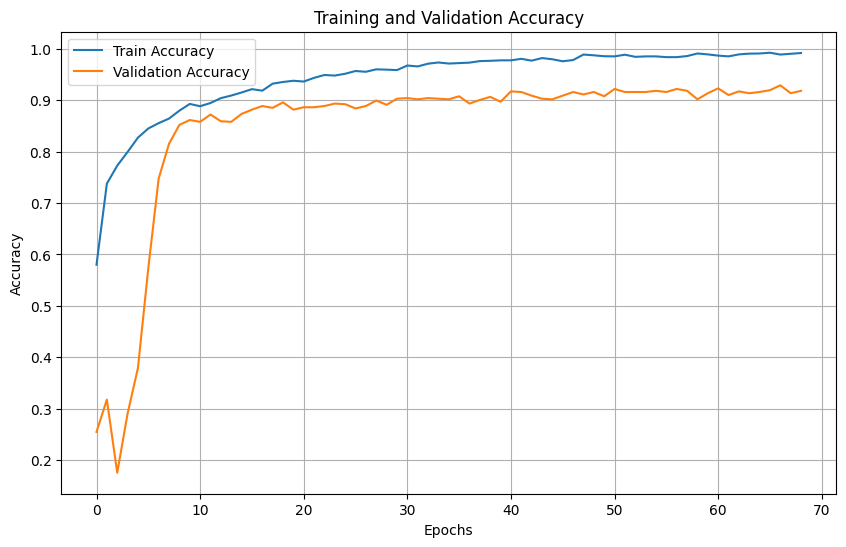

In [24]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

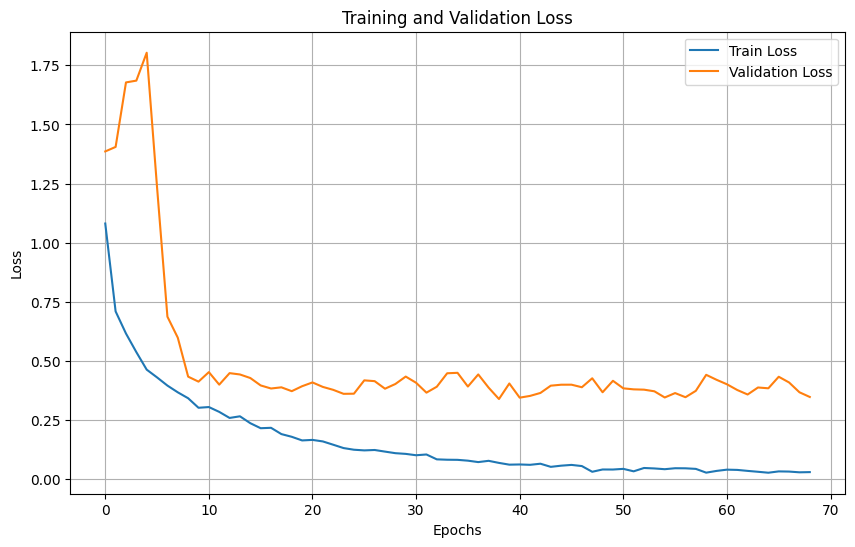

In [25]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()



                      precision    recall  f1-score   support

            cataract     0.9278    0.9184    0.9231       196
diabetic_retinopathy     0.9756    0.9600    0.9677       250
            glaucoma     0.9074    0.8033    0.8522       183
              normal     0.8182    0.9209    0.8665       215

            accuracy                         0.9064       844
           macro avg     0.9073    0.9006    0.9024       844
        weighted avg     0.9096    0.9064    0.9065       844



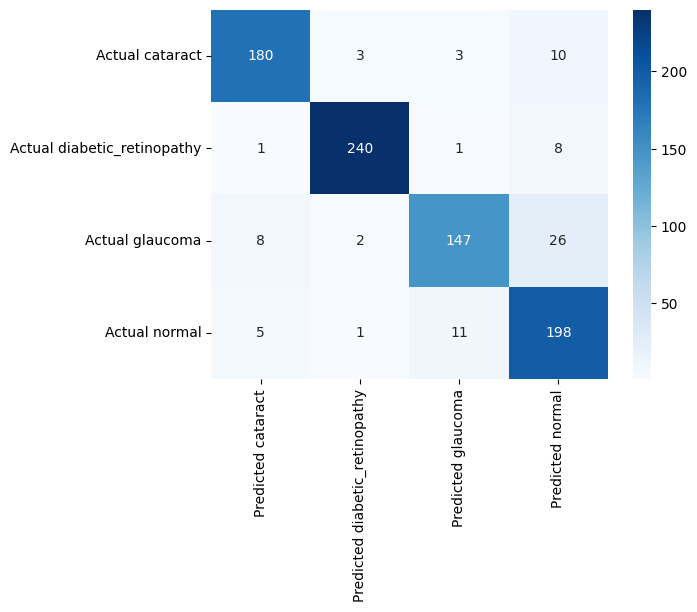

In [27]:
test_generator.reset()

preds_1 = model.predict(test_generator, verbose=0)
preds_1 = preds_1.argmax(axis=1)

labels = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=range(len(labels))),
                  index=[f"Actual {label}" for label in labels],
                  columns=[f"Predicted {label}" for label in labels])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

print("\n")
print(classification_report(y_true=test_generator.classes, y_pred=preds_1, target_names=labels, digits=4))

# 4. Model Convertion
## 4.1. Saved Model

In [28]:
saved_model_path = './saved_model_1/eye_diseases_model_1'
model.export(saved_model_path)
print(f"Model disimpan dalam format SavedModel di: {saved_model_path}")

Saved artifact at './saved_model_1/eye_diseases_model_1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  134377406630896: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134371365148928: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134371365071408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134371365069120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134371352475280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134371365068768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134371365068064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134371352477040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134371351085296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134371351087232: TensorSpec(shape=(), dtyp

## 4.2. TF-Lite

In [29]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

tflite_model_dir = './saved_model_1/tflite_model/'
os.makedirs(tflite_model_dir, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = os.path.join(tflite_model_dir, 'eye_diseases_model_1.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

labels = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

label_file_path = os.path.join(tflite_model_dir, 'label.txt')
with open(label_file_path, 'w') as f:
    for label in labels:
        f.write(f"{label}\n")

print(f"Model disimpan dalam format TF-Lite di: {tflite_model_path}")
print(f"Labels disimpan dalam file: {label_file_path}")

Saved artifact at '/tmp/tmp6cgcm_pb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  134377406630896: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134371365148928: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134371365071408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134371365069120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134371352475280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134371365068768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134371365068064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134371352477040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134371351085296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134371351087232: TensorSpec(shape=(), dtype=tf.resource, name=

## 4.3. Tensorflow.js

In [30]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 107.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [32]:
import tensorflowjs as tfjs

tfjs_model_dir = './saved_model_1/tfjs_model/'
os.makedirs(tfjs_model_dir, exist_ok=True)

tfjs_model_path = os.path.join(tfjs_model_dir, 'model')
tfjs.converters.save_keras_model(model, tfjs_model_path)

failed to lookup keras version from the file,
    this is likely a weight only file
weight normalization/count with shape () and dtype int64 was auto converted to the type int32


In [33]:
folder_to_zip = './saved_model_1'
zip_file_path = './eye_saved_model_1.zip'

shutil.make_archive(base_name=zip_file_path.replace('.zip', ''), format='zip', root_dir=os.path.dirname(folder_to_zip), base_dir=os.path.basename(folder_to_zip))

print(f"Folder '{folder_to_zip}' telah dikompres menjadi '{zip_file_path}'.")

Folder './saved_model_1' telah dikompres menjadi './eye_saved_model_1.zip'.


In [34]:
from google.colab import files

zip_file_path = './eye_saved_model_1.zip'
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 5. Inference with Saved Model

In [2]:
import zipfile
import os

zip_file_path = 'eye_saved_model_1.zip'
output_folder = 'eye_saved_model'

os.makedirs(output_folder, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_folder)

print(f"File telah diekstrak ke folder: {output_folder}")

File telah diekstrak ke folder: eye_saved_model


In [69]:
def predict_images(folder_path):
    model_path = './eye_saved_model/saved_model_1/eye_diseases_model_1'
    model = tf.saved_model.load(model_path)
    infer = model.signatures['serving_default']

    labels = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
    custom_labels = {
        'c': 'cataract',
        'dr': 'diabetic retinopathy',
        'h': 'healthy',
        'g': 'glaucoma'
    }

    images = []
    titles = []
    actual_labels = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image = Image.open(file_path)
            image = image.resize((224, 224))
            image_array = np.array(image).astype(np.float32) / 255.0
            image_array = np.expand_dims(image_array, axis=0)

            predictions = infer(tf.convert_to_tensor(image_array, dtype=tf.float32))['output_0']
            predicted_index = np.argmax(predictions.numpy(), axis=1)[0]
            predicted_probability = np.max(predictions.numpy()) * 100
            predicted_label = labels[predicted_index]

            actual_label = filename.split('_')[-1].split('.')[0]
            actual_label = custom_labels.get(actual_label, actual_label)

            title = f"actual: {actual_label}\n predicted: {predicted_label} ({predicted_probability:.2f}%)"
            titles.append(title)
            images.append(image)

    num_images = len(images)
    num_columns = 3
    num_rows = (num_images + num_columns - 1) // num_columns

    plt.figure(figsize=(13, num_rows * 5))

    for i in range(num_images):
        plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(titles[i])

    plt.suptitle("Prediction", y=0.85)
    plt.subplots_adjust(top=0.75, wspace=0.3, hspace=0.4)
    plt.show()

In [70]:
folder_path = '/content/new_eye_data'

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Folder '{folder_path}' telah dihapus.")
else:
    print(f"Folder '{folder_path}' tidak ditemukan.")

zip_file_path = '/content/new eye data.zip'
extract_to = '/content/new_eye_data'

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Folder {extract_to} telah dibuat")
print(f"File diekstrak ke {extract_to}")

Folder '/content/new_eye_data' telah dihapus.
Folder /content/new_eye_data telah dibuat
File diekstrak ke /content/new_eye_data


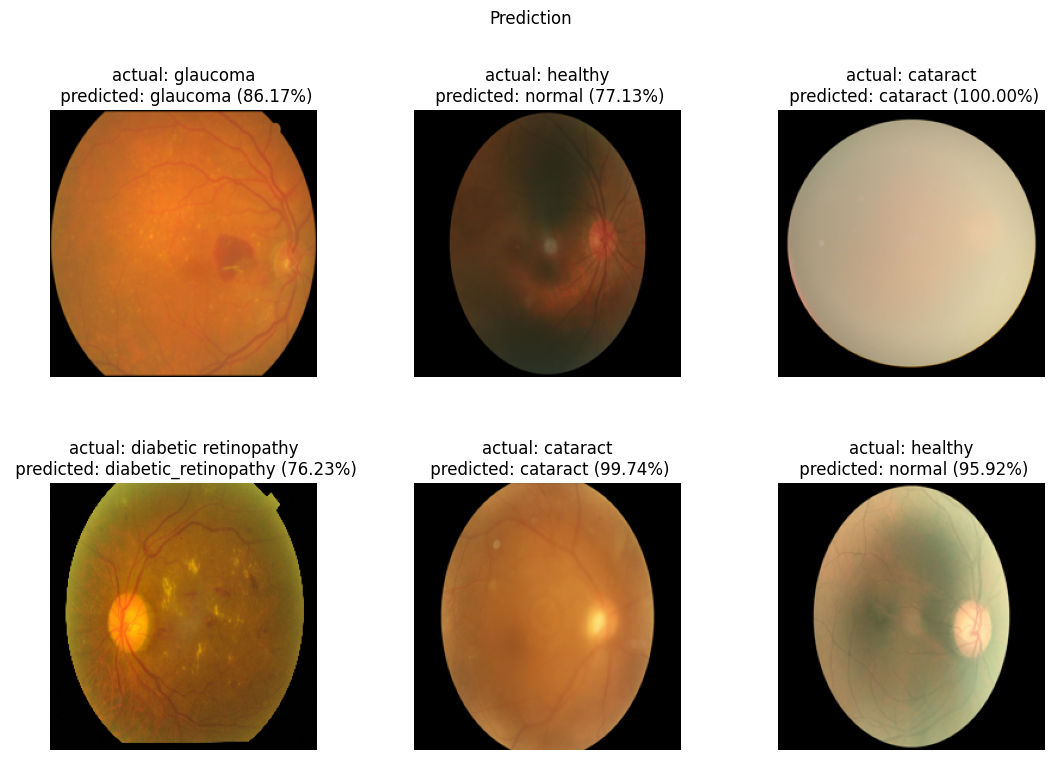

In [71]:
folder_path = '/content/new_eye_data/new eye data'
predict_images(folder_path)